In [8]:
import numpy as np
import pandas as pd
import datajoint as dj
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

In [9]:
ALL_ANIMALS = [
    "R500",
    "R501",
    "R502",
    "R503",
    "R600",
    "R610",
    "R611",
    "R612",
    "R613",
    "R614",
    "Y500",
    "Y501",
    "Y502",
    "Y503",
    "Y600",
    "Y601",
    "Y510",
    "Y511",
    "Y512",
    "Y513",
    "Y514",
    "W600",
    "W601",
    "W602",
    "W603",
    "W510",
    "W511",
    "W512",
    "W513",
]

In [10]:
MODE = "online"
if MODE == "online":
    ratinfo = dj.create_virtual_module("intfo", "ratinfo")

    ANIMALS = ALL_ANIMALS

    Mass_keys = [{"ratname": animal} for animal in ANIMALS]
    mass_df = pd.DataFrame((ratinfo.Mass & Mass_keys).fetch(as_dict=True))
    mass_df["mass"] = mass_df["mass"].replace(0, np.nan)
    mass_df.to_csv("mass_Ws.csv", index=False)

if MODE == "offline":
    mass_df = pd.read_csv("mass.csv")

In [11]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4636 entries, 0 to 4635
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   mass      4387 non-null   object         
 1   weighing  4636 non-null   int64          
 2   date      4636 non-null   object         
 3   ratname   4636 non-null   object         
 4   tech      4636 non-null   object         
 5   timeval   4636 non-null   timedelta64[ns]
dtypes: int64(1), object(4), timedelta64[ns](1)
memory usage: 217.4+ KB


### Calculate baseline weight- minimum date

In [12]:
# Convert the columns to numeric data type if needed
mass_df["mass"] = pd.to_numeric(mass_df["mass"], errors="coerce")

baseline_df = (
    mass_df.groupby("ratname").agg({"date": "min", "mass": "first"}).reset_index()
)
baseline_df.columns = ["ratname", "min_date", "min_date_mass"]

mass_df = pd.merge(mass_df, baseline_df, on="ratname", how="left")
mass_df["min_date_relative"] = (mass_df["mass"] / mass_df["min_date_mass"]).round(2)

mass_df["min_date_diff"] = mass_df.groupby("ratname")["min_date_relative"].diff()

## Plot

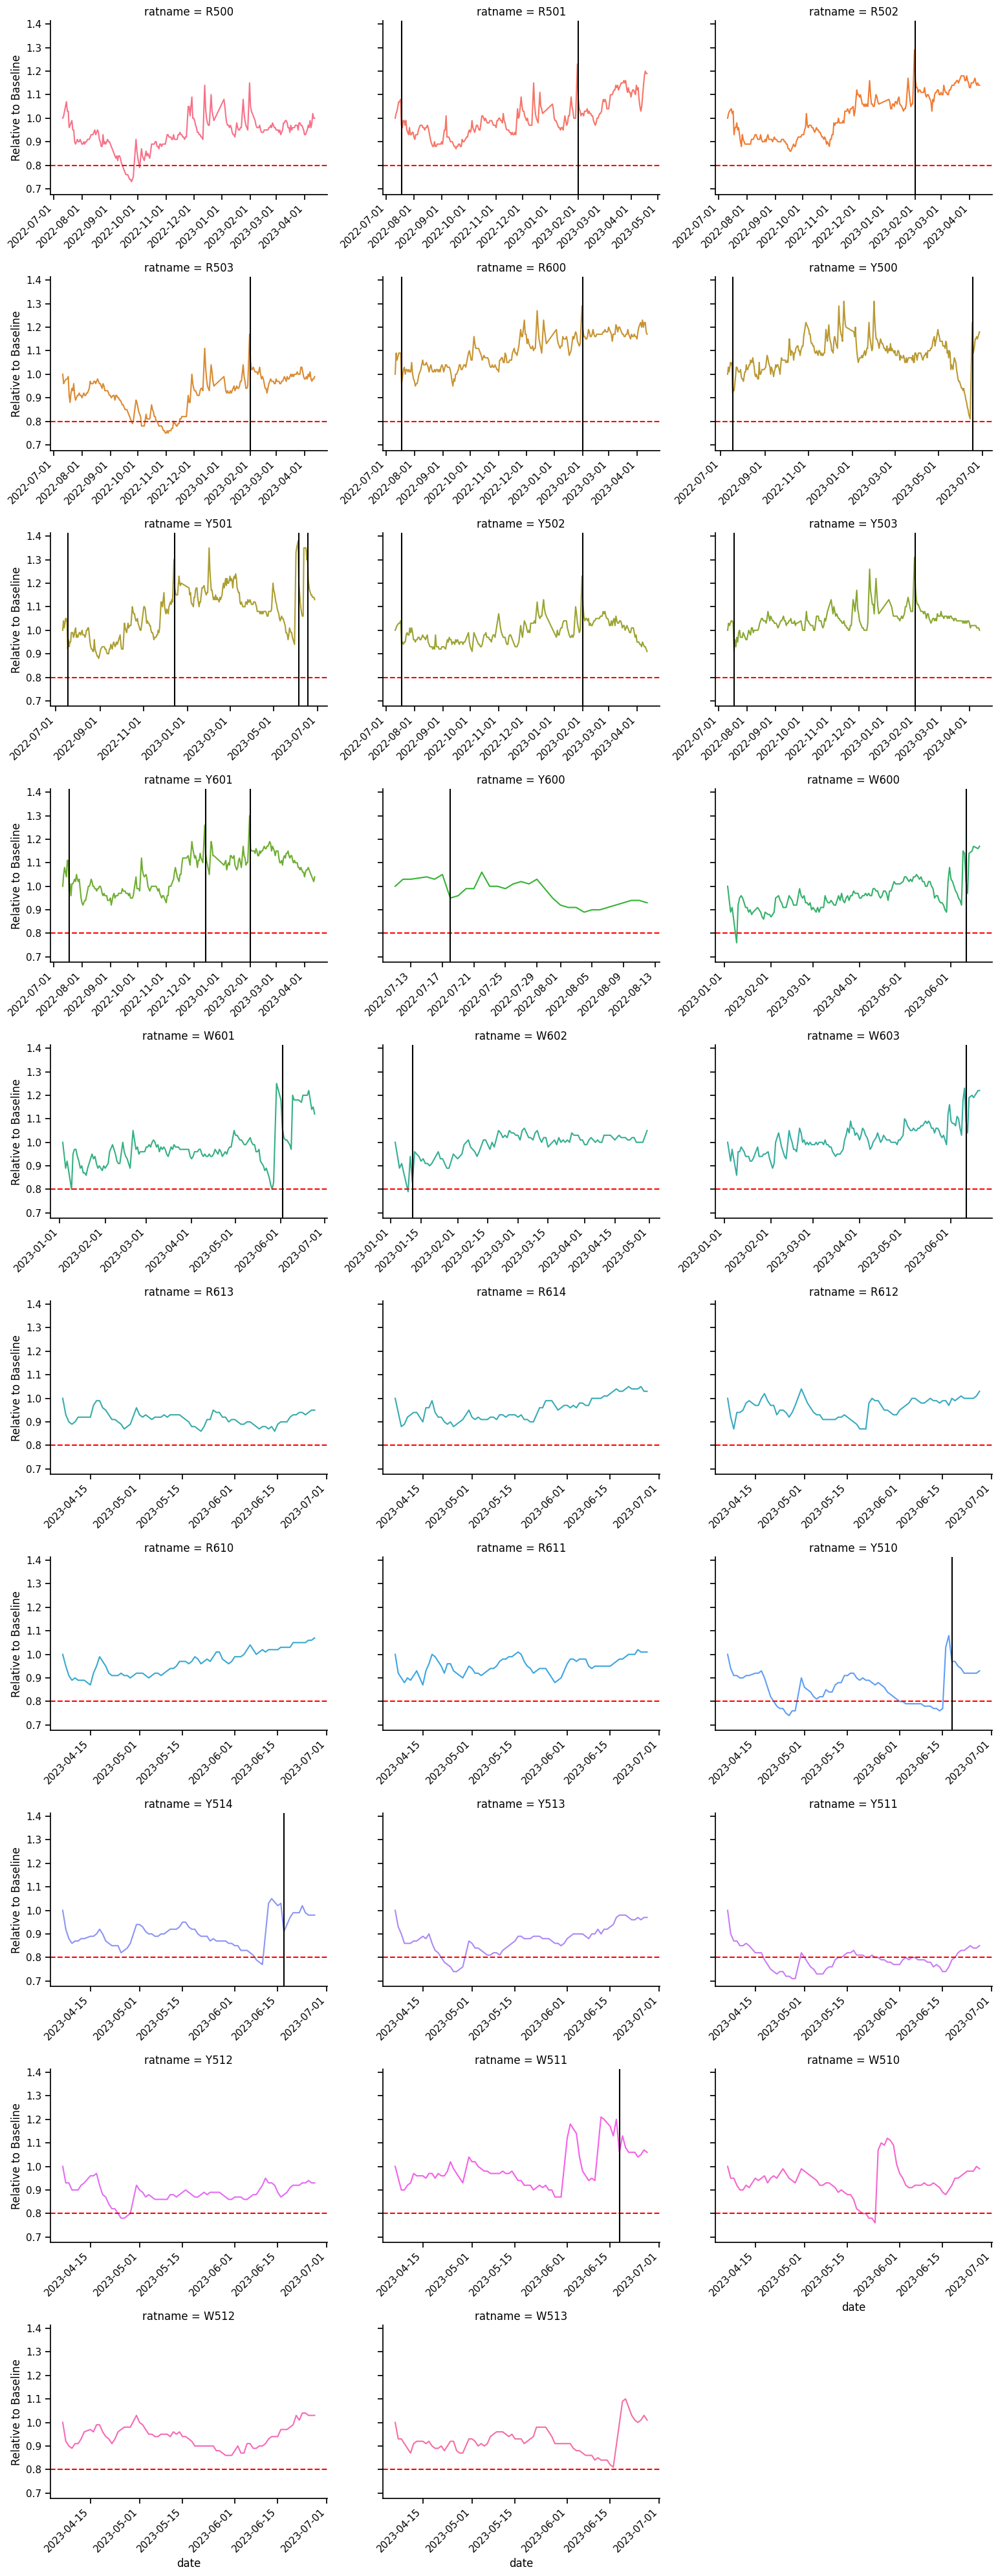

In [13]:
# Create the facet grid plot
g = sns.FacetGrid(
    data=mass_df,
    col="ratname",
    col_wrap=3,
    hue="ratname",
    height=4,
    sharex=False,
    aspect=1.3,
)
g.map(sns.lineplot, "date", "min_date_relative")
g.map(plt.axhline, y=0.80, color="red", linestyle="--")
g.set_xticklabels(rotation=45, ha="right")
# g.set_xticklabels()
g.fig.tight_layout()
g.set_axis_labels(y_var="Relative to Baseline")

# plot a vertical line every time there is more than a 10% drop day-to-day
for ax, ratname in zip(g.axes.flat, g.col_names):
    filtered_df = mass_df[mass_df["ratname"] == ratname]
    for _, row in filtered_df[filtered_df["min_date_diff"] < -0.10].iterrows():
        ax.axvline(x=row["date"], color="black")

Possible ideas:
* what was the first training day for the above animals?
* could there be a window of time that's more appropriate than the first day? Ie first 7 masses?

In [14]:
summary_df = mass_df.groupby("ratname").date.min().reset_index()
summary_df["n_weights"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.count()
)
summary_df["n_weights"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.count()
)
summary_df["min_weight"] = summary_df["ratname"].map(
    mass_df.query("mass > 0").groupby("ratname").mass.min()
)

summary_df["max_weight"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.max()
)

summary_df["min_date_weight"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").min_date_mass.min()
)

summary_df

,ratname,date,n_weights,min_weight,max_weight,min_date_weight
0,R500,2022-07-08,252,18.39,28.90,25.23
1,R501,2022-07-08,259,20.20,28.60,23.28
2,R502,2022-07-08,253,19.69,29.44,22.81
3,R503,2022-07-08,253,18.40,28.79,24.53
4,R600,2022-07-08,252,16.69,22.62,17.54
5,R610,2023-04-06,81,15.32,18.73,17.51
6,R611,2023-04-06,80,15.41,17.92,17.62
7,R612,2023-04-06,81,14.60,17.46,16.85
8,R613,2023-04-06,81,15.23,17.81,17.81
9,R614,2023-04-06,81,16.28,19.47,18.53


### Assessing male versus female mass differences

In [15]:
mass_df.head()

,mass,weighing,date,ratname,tech,timeval,min_date,min_date_mass,min_date_relative,min_date_diff
0,NaN,1077880,2022-07-08,R500,FW,0 days 16:49:47,2022-07-08,25.23,NaN,NaN
1,NaN,1077881,2022-07-08,R501,FW,0 days 16:49:47,2022-07-08,23.28,NaN,NaN
2,NaN,1077882,2022-07-08,R502,FW,0 days 16:49:47,2022-07-08,22.81,NaN,NaN
3,NaN,1077883,2022-07-08,R503,FW,0 days 16:49:47,2022-07-08,24.53,NaN,NaN
4,NaN,1077884,2022-07-08,R600,FW,0 days 16:49:47,2022-07-08,17.54,NaN,NaN


In [25]:
# if there is a 5 in the name, it's a male, else, female (for now)
mass_df["sex"] = np.where(mass_df["ratname"].str.contains("5"), "male", "female")

In [40]:
mass_df.groupby("ratname").head()

,mass,weighing,date,ratname,tech,timeval,min_date,min_date_mass,min_date_relative,min_date_diff,sex
0,NaN,1077880,2022-07-08,R500,FW,0 days 16:49:47,2022-07-08,25.23,NaN,NaN,male
1,NaN,1077881,2022-07-08,R501,FW,0 days 16:49:47,2022-07-08,23.28,NaN,NaN,male
2,NaN,1077882,2022-07-08,R502,FW,0 days 16:49:47,2022-07-08,22.81,NaN,NaN,male
3,NaN,1077883,2022-07-08,R503,FW,0 days 16:49:47,2022-07-08,24.53,NaN,NaN,male
4,NaN,1077884,2022-07-08,R600,FW,0 days 16:49:47,2022-07-08,17.54,NaN,NaN,female
...,...,...,...,...,...,...,...,...,...,...,...
3170,21.79,1120618,2023-04-10,Y513,JL,0 days 10:29:46,2023-04-06,25.44,0.86,0.00,male
3171,20.84,1120619,2023-04-10,Y510,JL,0 days 10:31:07,2023-04-06,23.21,0.90,-0.01,male
3172,20.01,1120620,2023-04-10,Y514,JL,0 days 10:31:43,2023-04-06,22.94,0.87,0.01,male
3173,21.78,1120622,2023-04-10,Y511,JL,0 days 10:32:32,2023-04-06,25.49,0.85,-0.02,male


In a boxen plot, the central box represents the interquartile range (IQR), which spans the middle 50% of the data. The height of the box indicates the range of the IQR. The median is typically displayed as a horizontal line within the box.

Additionally, boxen plots divide the data into smaller quantiles, known as "boxes," within the central box. These boxes provide a more granular representation of the distribution, especially for datasets with large sample sizes. The width of each box is proportional to the square root of the number of observations in that group.

Outliers are displayed as individual points beyond the whiskers, which extend from the central box. Unlike traditional box plots, boxen plots show a varying number of whiskers, adapting to the density of the data.

<Axes: xlabel='sex', ylabel='mass'>

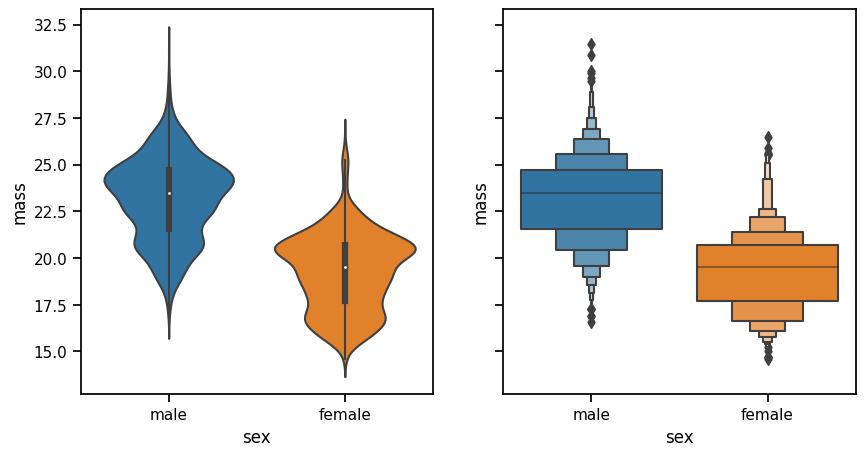

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.violinplot(data=mass_df, x="sex", y="mass", ax=ax[0])
sns.boxenplot(data=mass_df, x="sex", y="mass", ax=ax[1])

#### Mass over time

In [54]:
mass_df = mass_df.sort_values(["ratname", "date"])

mass_df["n_weighings"] = mass_df.groupby(["ratname"]).cumcount()

[Text(0.5, 1.0, 'Mass over time'),
 Text(0.5, 0, 'Number of weighings'),
 Text(0, 0.5, 'Mass (g)')]

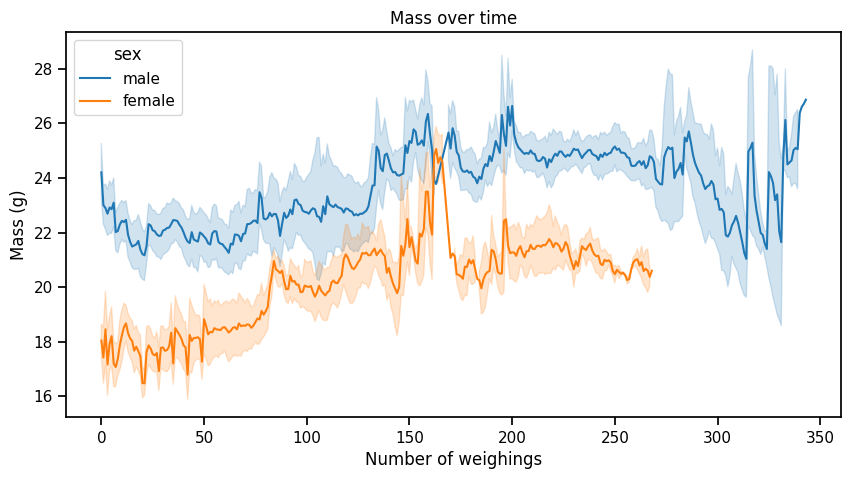

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=mass_df, x="n_weighings", y="mass", hue="sex", ax=ax)
ax.set(title="Mass over time", xlabel="Number of weighings", ylabel="Mass (g)")